In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, linalg, stats
from sklearn.preprocessing import StandardScaler

from aps_data_handler import APSDataHandler

In [2]:
t = APSDataHandler('/sdf/group/ml/datasets/bes_anomaly_data/PSTrips-2020-01-13.h5')

In [3]:
# t.printScenarios()

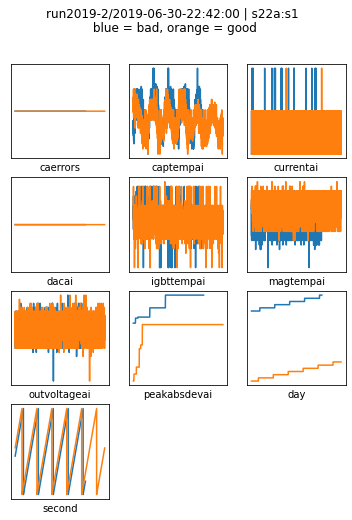

In [4]:
t.plotBadVersusGood('run2019-2/2019-06-30-22:42:00')

In [5]:
def featurizeData(dd):
    """
    """
    out = np.array([])
    for key in dd.keys():
        if key in ['day', 'second']:
            continue
        out = np.hstack((out, dd[key]['series']))
    dl = len(dd[key]['series'])
    return out.reshape((len(out) // dl, dl))

def omega(beta):
    """ follows http://www.pyrunner.com/weblog/2016/08/01/optimal-svht/ """
    coef = [0.56, -0.95, 1.82, 1.43]
    poly = [beta ** (3 - n) for n in range(4)]
    return sum([c*p for c,p in zip(coef, poly)])

def anomaly_score(test, train):
    """
    Returns an anomaly score for each member in test.  The score is computed as the fraction of 
    values in train that are less than the values of test, for each value of test.
    
    Parameters
    ----------
    test : ndarray
        The array of test points.
    train : ndarray
        The array of the train points
        
    Returns
    -------
    ndarray of scores
    """
    res = np.zeros_like(test, dtype=float)
    mag = len(train)
    for idx, val in enumerate(test):
        res[idx] = (val > train).sum() / mag
    return res

def computeSignal(matrix):
    """
    Computes the signal part of the SVD.
    
    Parameters
    ----------
    matrix : ndarray
        The matrix to SVD
        
    Returns
    -------
    ndarray shaped like test
    """
    u, s, vh = np.linalg.svd(matrix, full_matrices = False)
    beta = np.min(matrix.shape) / np.max(matrix.shape)
    med_sv = np.median(s)
    med_idx = np.argpartition(s, len(s) // 2)[len(s) // 2]
    t_star = omega(beta) * med_sv
    
    out = np.zeros_like(matrix, dtype=float)
    num_sing = (s > t_star).sum()
    for idx in range(1, 2 * num_sing):
        u1 = u[:, idx]
        v1 = vh[idx, :]
        s1 = s[idx]
        out += s1 * np.outer(u1, v1)
    return out

def makeSVDPlot(matrix, num_extra=2, title=''):
    """
    Computes the SVD and make a plot of the singular vectors.
    
    Parameters
    ----------
    matrix : ndarray
        The matrix to SVD
    num_extra : int
        The number of 'non-signal' singular values to show
        in addition to the 'signal' singular values.
    """
    u, s, vh = np.linalg.svd(matrix, full_matrices = False)
    med_sv = np.median(s)
    med_idx = np.argpartition(s, len(s) // 2)[len(s) // 2]  # can probably use len(s) // 2
    beta = min(matrix.shape) / max(matrix.shape)
    t_star = omega(beta) * med_sv
    num_sing = (s > t_star).sum()
    num_svds = num_sing + num_extra
    fig, axs = plt.subplots(num_svds, 3, 
                            sharex='col', figsize=(16,3 * num_svds), 
                            gridspec_kw={'width_ratios': [1, 3, 1]})
    plt.suptitle(title)
    for idx, ax in enumerate(axs):
        if idx < num_sing:
            color = 'b'
        else:
            color = 'r'
        offset = np.mean(vh[idx, :])
        v = vh[idx, :] - offset
        
        ax[0].bar(x=range(matrix.shape[0]), height=u[:, idx], width=0.9, align='center')
        
        ax[1].plot(range(matrix.shape[1]), v, color=color, linestyle='-')
        ax[1].set_ylabel('feature')
        ax[1].set_title('Singular Value = {:4.3e}, offset = {:4.3e}'.format(s[idx], offset))
        ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

        ax[2].hist(v, bins=30, color=color)
        ax[2].set_title('Std: {:4.3e}'.format(np.std(v)))

    _ = ax[0].set_xlabel('feature')  
    _ = ax[1].set_xlabel('time')

In [6]:
def returnMagnetFeatures(t: APSDataHandler, 
                   run: str = 'run2019-2', 
                   bad_scenario: str = '2019-06-30-22:42:00') -> dict:
    """
    Returns magnet data in dictionary form.
    
    Parameters
    ----------
    t : APSDataHandler
        An APS data handler instance.
    run : str
        The name of a run in the data handler.
    bad_scenario : str
        The name of one of the bad scenarios in the run.
        
    Returns
    -------
    A dictionary.
    """
    path = path = '/'.join([run, bad_scenario])
    scenarios = {}  # fill me with dictionaries
    with t as hdf:
        # the sector / magnet to watch for all runs
        tar_sec = hdf[path].attrs['badSector']
        tar_mag = hdf[path].attrs['badMagnet']
        for name in hdf[run].keys():
            dd = {}
            dd['data'] = featurizeData(t.getMagnetFeatures(hdf,run,name,tar_sec,tar_mag))
            # the sector / magnet that are bad for this run
            dd['bad_sec'] = hdf['/'.join([run, name])].attrs['badSector']
            dd['bad_mag'] = hdf['/'.join([run, name])].attrs['badMagnet']
            dd['tar_sec'] = tar_sec
            dd['tar_mag'] = tar_mag
            scenarios[name] = dd
    return scenarios

def compareMagnets(t: APSDataHandler, 
                   run: str = 'run2019-2', 
                   bad_scenario: str = '2019-06-30-22:42:00',
                   num_extra: int = 2
                  ):
    """
    Plots the 'signal' SVD components.
    
    Parameters
    ----------
    t : APSDataHandler
        An APS data handler instance.
    run : str
        The name of a run in the data handler.
    bad_scenario : str
        The name of one of the bad scenarios in the run.
    num_extra : int
        The number of singular values to plot beyond the 'signal'
        terms.
    """
    scenarios = returnMagnetFeatures(t, run, bad_scenario)
            
    for name, scen in scenarios.items():
        tm = '/'.join([scen['tar_sec'], scen['tar_mag']])
        bm = '/'.join([scen['bad_sec'], scen['bad_mag']])
        title = '{:s} | Magnet Used: {:s} | Bad Magnet: {:s}'.format(name, tm, bm)
        makeSVDPlot(scen['data'], num_extra=num_extra, title=title)
        
def plotVs(t: APSDataHandler, 
                   run: str = 'run2019-2', 
                   bad_scenario: str = '2019-06-30-22:42:00'
          ):
    """
    Plots log(abs(vh)) for all the scenarios using U and S from
    the referenceData.
    
    Parameters
    ----------
    t : APSDataHandler
        An APS data handler instance.
    run : str
        The name of a run in the data handler.
    bad_scenario : str
        The name of one of the bad scenarios in the run.
    """
    scenarios = returnMagnetFeatures(t, run, bad_scenario)
    # SVD the reference data
    u, s, vh = np.linalg.svd(scenarios['referencedata']['data'], full_matrices=False)
    T = np.linalg.inv(np.diag(s)) @ np.linalg.inv(u)
#     T = np.linalg.inv(u)
    # apply the inverse transform to all of the scenarios and plot them
    fig, axs = plt.subplots(len(scenarios.keys()), 1, 
                            sharex='col', figsize=(16,3 * len(scenarios.keys())), 
                            gridspec_kw={'width_ratios': [1]})
    for idx, (ax, name) in enumerate(zip(axs, scenarios.keys())):        
        v = T @ scenarios[name]['data']
        ax.imshow(np.log(np.abs(v)), aspect='auto')
        if name == bad_scenario:
            color = 'r'
        else:
            color = 'k'
        ax.set_title(name, color=color)

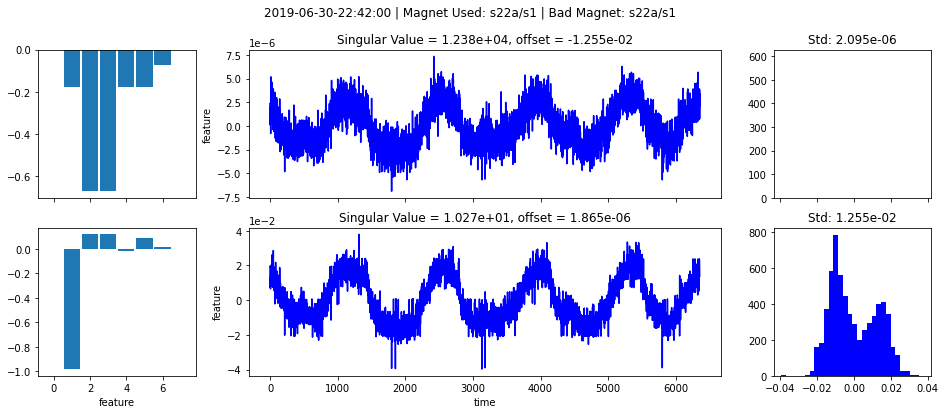

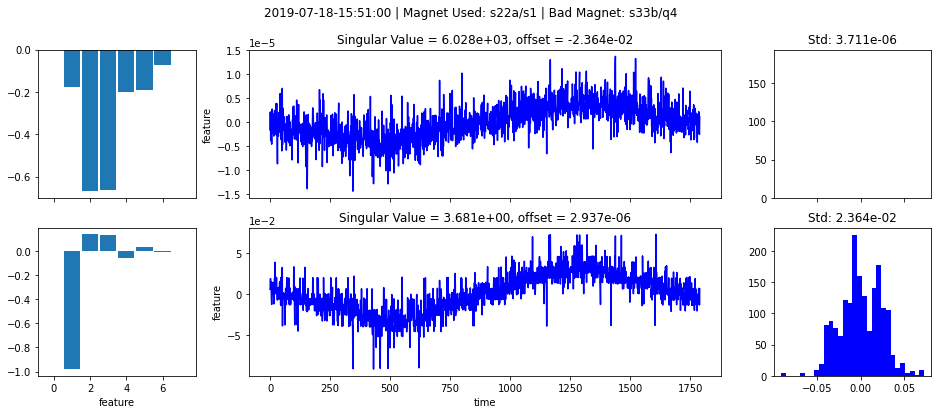

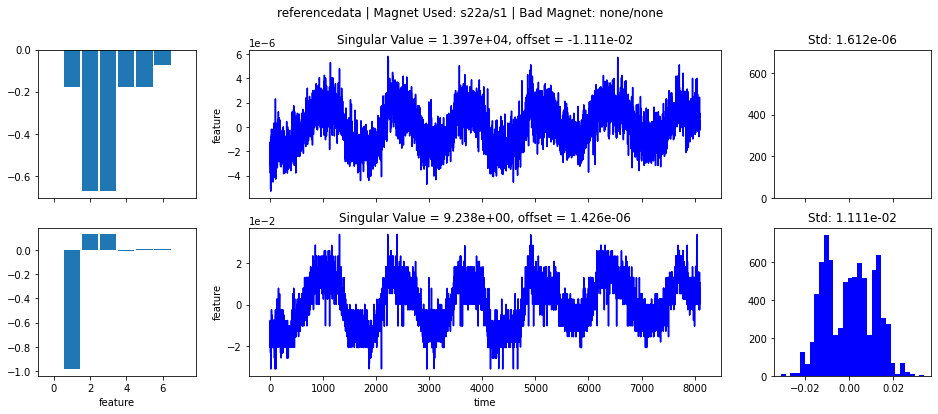

In [7]:
compareMagnets(t, run='run2019-2', bad_scenario='2019-06-30-22:42:00', num_extra=0)

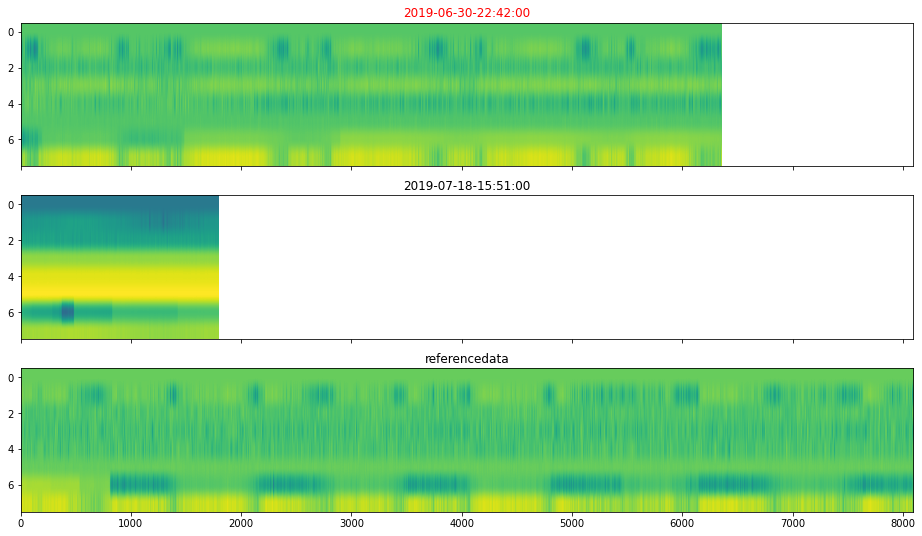

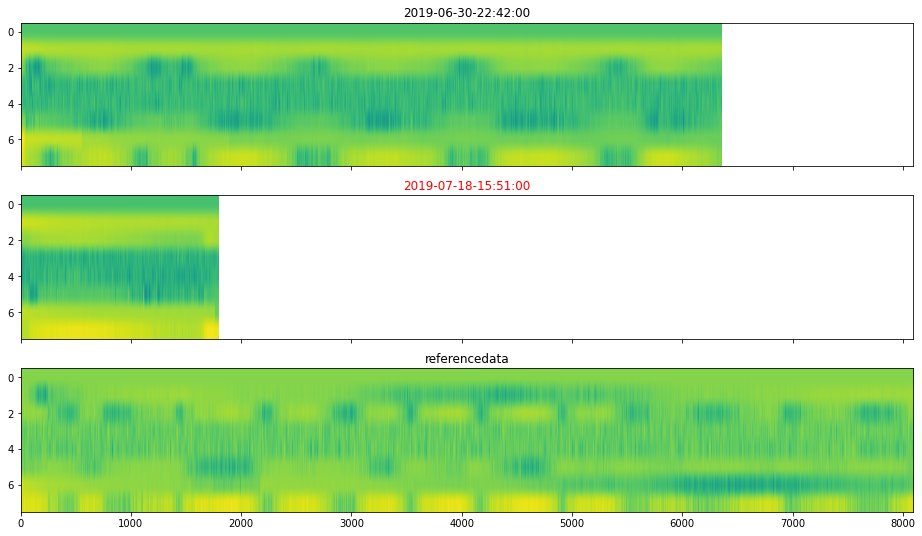

In [8]:
plotVs(t, run='run2019-2', bad_scenario='2019-06-30-22:42:00')
plotVs(t, run='run2019-2', bad_scenario='2019-07-18-15:51:00')

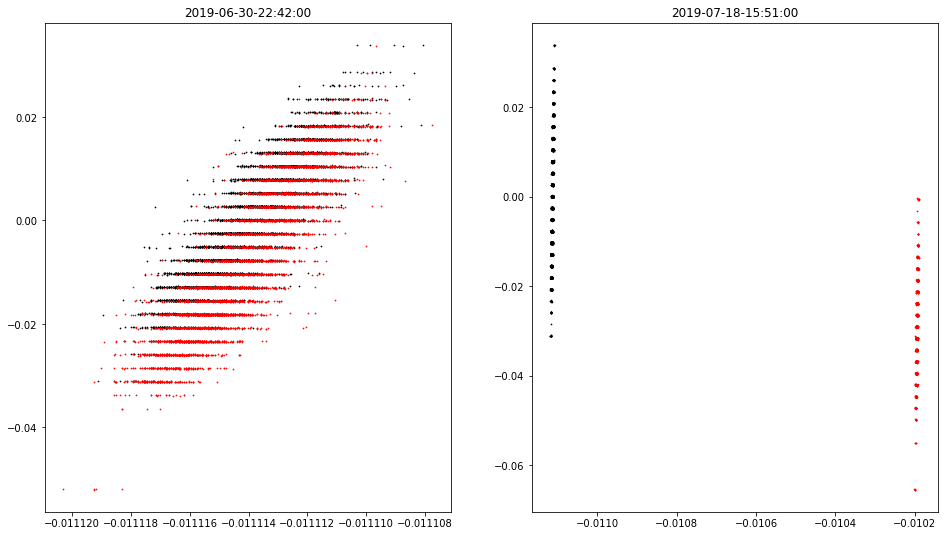

In [36]:
scenarios = returnMagnetFeatures(t, run='run2019-2', bad_scenario='2019-06-30-22:42:00')
# scenarios = returnMagnetFeatures(t, run='run2019-2', bad_scenario='2019-07-18-15:51:00')
# SVD the reference data
u, s, vh = np.linalg.svd(scenarios['referencedata']['data'], full_matrices=False)
T = np.linalg.inv(np.diag(s)) @ np.linalg.inv(u)

num_other = len(scenarios.keys()) - 1
fig, axs = plt.subplots(1, num_other, 
                        sharex='col', figsize=(16,3 * len(scenarios.keys())), 
                        gridspec_kw={'width_ratios': [1] * num_other})

for name, ax in zip(scenarios.keys(), axs):
    if name != 'referencedata':
        v = T @ scenarios[name]['data']
        ax.scatter(vh[0, :], vh[1, :], s=2, marker='.', color='k')
        ax.scatter(v[0, :], v[1, :], s=2, marker='.', color='r')
        ax.set_title(name)

## SVD the good data to get a basis for the bad

In [ ]:
with t as hdf:
    run = 'run2019-2'
    scenario = '2019-06-30-22:42:00'
    path = '/'.join([run, scenario])
    # the features of the magnet that is bad
    bm = t.getMagnetFeatures(hdf, run, scenario, hdf[path].attrs['badSector'], hdf[path].attrs['badMagnet'])
    # the same magnet during the reference run
    gm = t.getMagnetFeatures(hdf, run, 'referencedata', hdf[path].attrs['badSector'], hdf[path].attrs['badMagnet'])
    # get the same features from a different run - the 'bad magnet' isn't the problem here
    scenario2 = '2019-07-18-15:51:00'
    bm2 = t.getMagnetFeatures(hdf, run, scenario2, hdf[path].attrs['badSector'], hdf[path].attrs['badMagnet'])
    

bm.keys()

bad_mag = featurizeData(bm)  # faulty magnet
bad_mag_2 = featurizeData(bm2)  # same magnet but not faulty
good_mag = featurizeData(gm)  # faulty magnet during reference run

shape of good_mag: (8, 8096)
median singular value is 3.470
There are 2 signal singular values


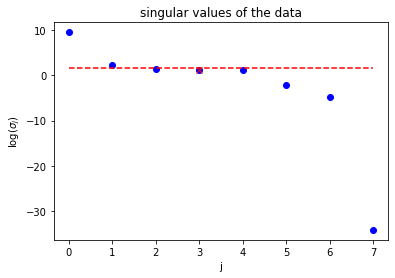

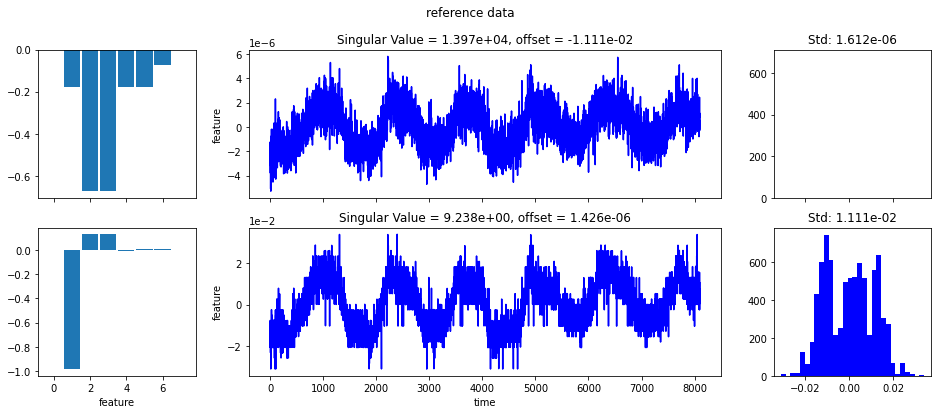

In [73]:
u, s, vh = np.linalg.svd(good_mag, full_matrices = False)
med_sv = np.median(s)
med_idx = np.argpartition(s, len(s) // 2)[len(s) // 2]  # can probably use len(s) // 2
beta = min(good_mag.shape) / max(good_mag.shape)
t_star = omega(beta) * med_sv
num_sing = (s > t_star).sum()
print('shape of good_mag: {:}'.format(good_mag.shape))
print('median singular value is {:4.3f}'.format(med_sv))
print('There are {:d} signal singular values'.format(num_sing))

plt.plot(range(len(s)),np.log(s),'ob')
plt.plot(med_idx, np.log(med_sv), 'xr')
plt.plot([0,len(s) - 1],[np.log(t_star)] * 2, '--r')
plt.xlabel('j')
plt.ylabel(r'log($\sigma_j$)')
plt.title('singular values of the data')
plt.show()

makeSVDPlot(good_mag, num_extra=0, title='reference data')

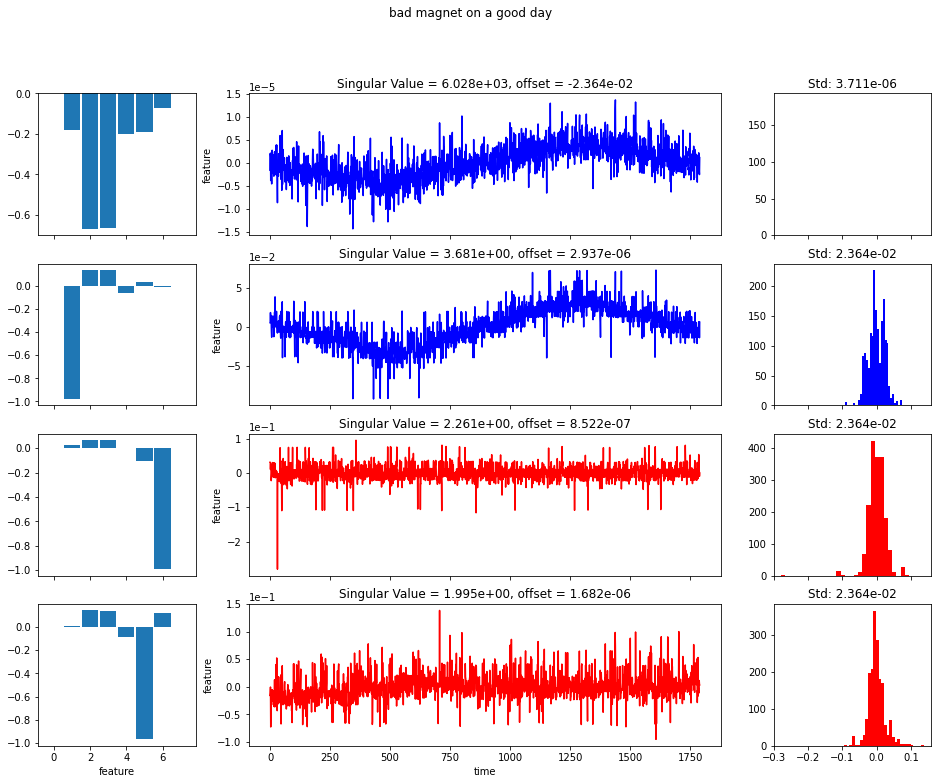

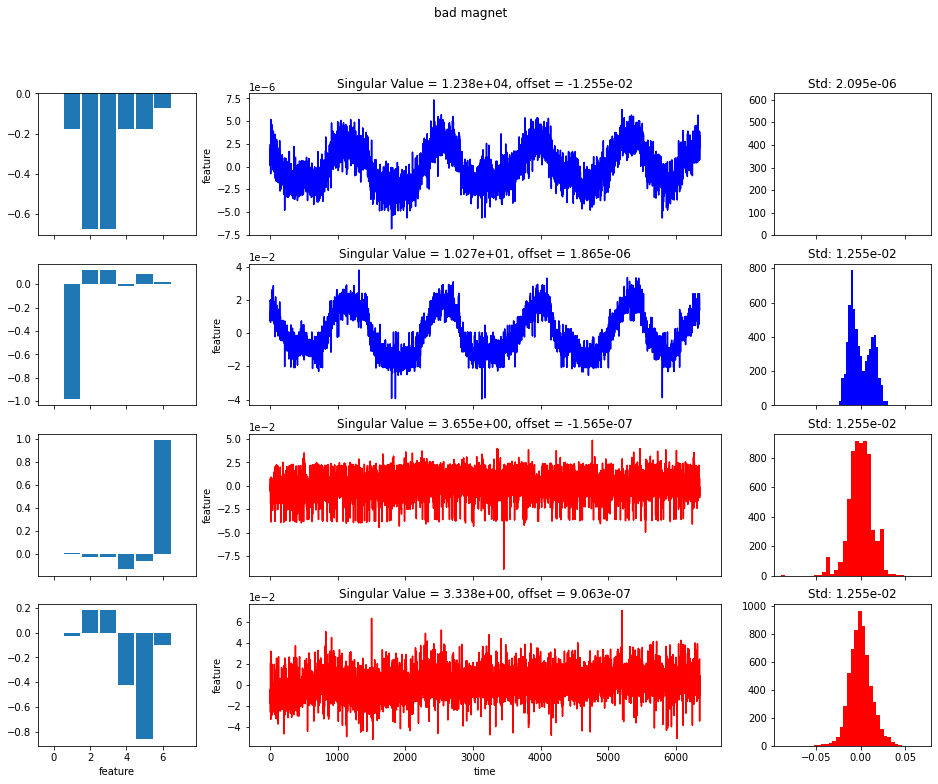

In [75]:
makeSVDPlot(bad_mag_2, title = 'bad magnet on a good day')
makeSVDPlot(bad_mag, title='bad magnet')

## Trains on the first part of the data to look at the last

shape of a: (8, 8096)
median singular value is 2.428
There are 2 signal singular values


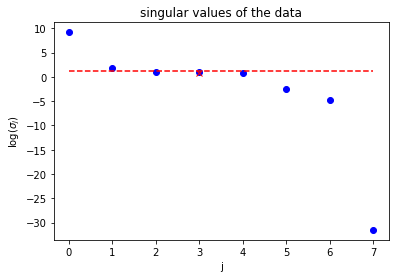

In [80]:
a = good_mag.copy()
n_max = a.shape[1] // 2  # how many time steps to keep

scaler = StandardScaler()

train = a[:,:n_max].copy()
test = a[:,n_max:].copy()
bad_data = bad_mag.copy()
bad_data_2 = bad_mag_2.copy()

# scaling causes there to be no signal values
# scaler.fit(train.T)
# train = scaler.transform(train.T).T
# test = scaler.transform(test.T).T
# bad_data = scaler.transform(bad_mag.T).T

u, s, vh = np.linalg.svd(train, full_matrices = False)
med_sv = np.median(s)
med_idx = np.argpartition(s, len(s) // 2)[len(s) // 2]  # can probably use len(s) // 2
beta = min(train.shape) / max(train.shape)
t_star = omega(beta) * med_sv
print('shape of a: {:}'.format(a.shape))
print('median singular value is {:4.3f}'.format(med_sv))
print('There are {:d} signal singular values'.format((s > t_star).sum()))

plt.plot(range(len(s)),np.log(s),'ob')
plt.plot(med_idx, np.log(med_sv), 'xr')
plt.plot([0,len(s) - 1],[np.log(t_star)] * 2, '--r')
plt.xlabel('j')
plt.ylabel(r'log($\sigma_j$)')
plt.title('singular values of the data')
plt.show()

There are 2 signal singular values


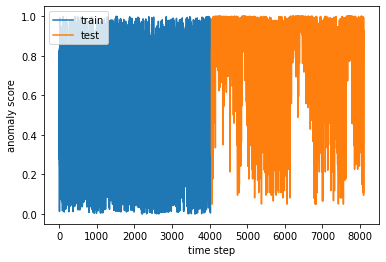

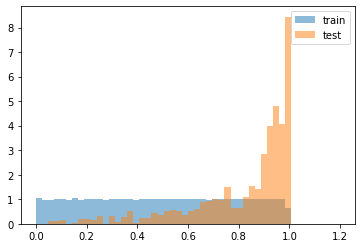

In [84]:
# compute the "signal" for the training data
threshold = t_star
sv = s.copy()
sv[sv < threshold] = 0
av = np.dot(np.dot(u, np.diag(sv)), vh)
print('There are {:d} signal singular values'.format((sv > threshold).sum()))


# compute the "signal" for the test data
tv = computeSignal(u, s, vh, test, t_star)

###### compute the anomaly score ######
train_values = np.power(train - av, 2).sum(axis=0)  # training values
test_values = np.power(test - tv, 2).sum(axis=0)  # test values
train_as = anomaly_score(train_values, train_values)  # train anomaly scores
test_as = anomaly_score(test_values, train_values)  # test anomaly scores
# train_as = -1 * np.log(anomaly_score(train_values, train_values) + 1e-6)  # train anomaly scores
# test_as = -1 * np.log(anomaly_score(test_values, train_values) + 1e-6)  # test anomaly scores

###### compute the anomaly score using Chebyshev distance ######
# train_as = np.max(np.abs(train - av), axis=0)
# test_as = np.max(np.abs(test - tv), axis=0)

all_as = np.hstack((train_as, test_as))

plt.plot(range(len(train_as)), train_as, label='train')
plt.plot(range(len(train_as),len(train_as) + len(test_as)), test_as, label='test')
plt.legend(loc='upper left')
plt.xlabel('time step')
plt.ylabel('anomaly score')
plt.show()

max_value = np.max([np.max(train_as), np.max(test_as)])
tr, bins, _ = plt.hist(train_as, bins=50, range=(0, 1.2 * max_value), density=True, alpha=0.5, label="train")
te, bins, _ = plt.hist(test_as, bins=50, range=(0, 1.2 * max_value), density=True, alpha = 0.5, label="test")
plt.legend(loc='upper right')
plt.show()

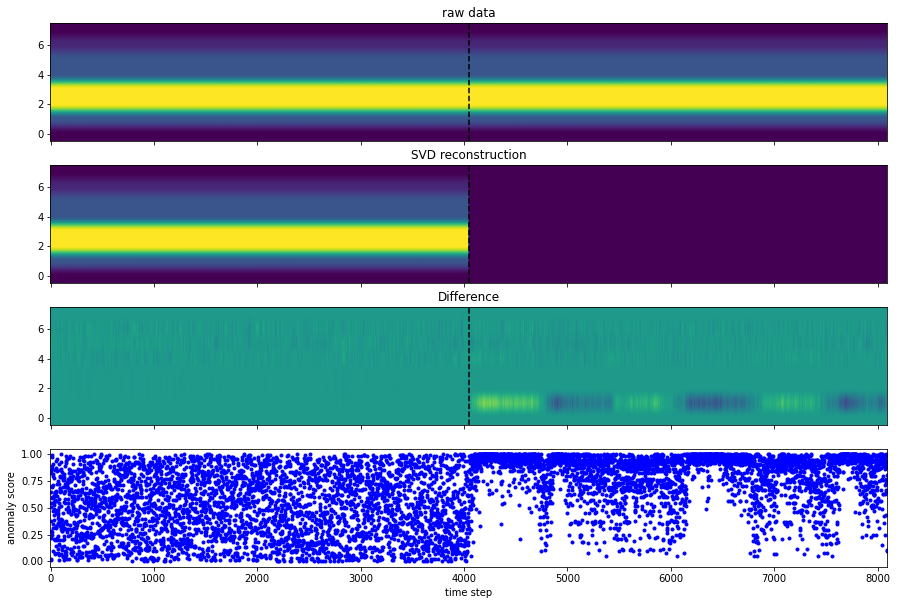

In [85]:
fig, axs = plt.subplots(4, 1, squeeze=True, sharex=True, figsize=(15,10))
axs[0].imshow(np.hstack((train, test)), origin='lower', aspect='auto')
axs[0].set_title('raw data')
axs[1].imshow(np.hstack((av, np.zeros_like(test, dtype=float))), origin='lower', aspect='auto')
axs[1].set_title('SVD reconstruction')
axs[2].imshow(np.hstack((train - av, test - tv)), origin='lower', aspect='auto')
axs[2].set_title('Difference')
axs[3].plot(range(a.shape[1]), all_as,'.b')
axs[3].set_xlabel('time step')
axs[3].set_ylabel('anomaly score')

for ax in axs[:-1]:
    ax.vlines([n_max-1], -0.5, train.shape[0]-0.5, colors=['k'], linestyles='dashed')

plt.show()

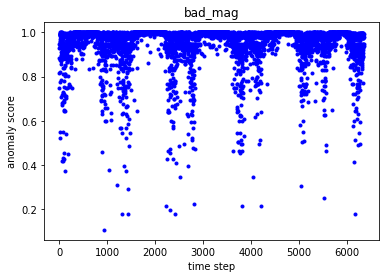

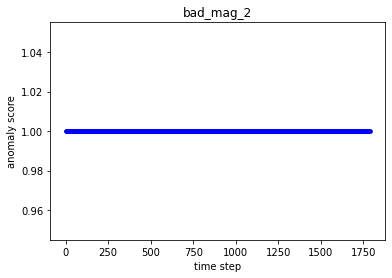

In [86]:
# compute the "signal" for the bad_magnet data
bv = computeSignal(u, s, vh, bad_data, t_star)
bv2 = computeSignal(u, s, vh, bad_data_2, t_star)

###### compute the anomaly score ######
bad_values = np.power(bad_data - bv, 2).sum(axis=0)  # test values
bad_as = anomaly_score(bad_values, train_values)  # bad_magnet anomaly scores
bad_values_2 = np.power(bad_data_2 - bv2, 2).sum(axis=0)  # test values
bad_as_2 = anomaly_score(bad_values_2, train_values)  # bad_magnet anomaly scores

plt.plot(range(bad_as.shape[0]), bad_as,'.b')
plt.xlabel('time step')
plt.ylabel('anomaly score')
plt.title('bad_mag')
plt.show()

plt.plot(range(bad_as_2.shape[0]), bad_as_2,'.b')
plt.xlabel('time step')
plt.ylabel('anomaly score')
plt.title('bad_mag_2')
plt.show()